# Simulation Studies 

(Estimation and Inference for Nonparametric Expected Shortfall Regression over RKHS)

## 1. Imports

In [2]:
import numpy as np
import pandas as pd
import numpy.random as rgt
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

from joblib import Parallel, delayed
from tqdm.notebook import tqdm
from scipy.stats import norm

from utl import *
from quantes.linear import joint
from quantes.nonlinear import KRR, LocPoly

## 2. Estimation under Multivariate Model

Three methods are implemented: 

* linear ES regression (`quantes.linear.joint()`)
    
* local linear ES regression (`quantes.nonlinear.LocPoly()`, ES-LLR)
    
* kernel ridge ES regression (`quantes.nonlinear.KRR()`, ES-KRR)

Data are generated from a location-scale model $y = m(x) + s(x) \varepsilon$, where $x = (x_1, \ldots, x_8)^T \sim {\rm Uniform}([0, 1]^8)$, $\varepsilon \sim N(0, 1)$, and
\begin{align*}
    &\begin{cases}
 m(x) = \cos(2\pi x_1) + (1 + e^{-x_2 - x_3})^{-1} +  (1 + x_4 + x_5)^{-3} + (x_6 + e^{x_7x_8})^{-1} ,   \\
 s(x) =  \sin(\pi (x_1+x_2)/2 ) + \log(1 + x_3^2x_4^2x_5^2) +  x_8(1 + e^{-x_6-x_7})^{-1} . 
    \end{cases} 
\end{align*}

### Setting and functions

In [3]:
tau = 0.2 # quantile level
grid_q = np.exp(np.linspace(-2, 1, 20)) # a grid of ridge penalty levels for quantile-KRR
grid_e = np.exp(np.linspace(1, 2, 20))  # a grid of ridge penalty levels for ES-KRR
bw_q = np.exp(np.linspace(-2, 0, 20))   # a grid of bandwidths for quantile-LLR
bw_e = np.exp(np.linspace(-2, 1, 20))   # a grid of bandwidths for ES-LLR

ntrains = np.array(range(500, 4001, 500)) # a sequence of training sample sizes
nvals = ntrains // 4                      # a sequence of validation sample sizes (for 
                                          # choosing tuning parameters)
ntest = 1000                              # test sample size

es = norm.expect(lambda x : (x if x <= norm.ppf(tau) else 0)) / tau # true tau-ES of N(0, 1) 
X_test, Y_test = gen_test_data(ntest, random_state=2024) # generate test data
test_e = md_fn(X_test) + sd_fn(X_test)*es # true conditional ES of test data

In [3]:
def multivariate_sim(i):
    error_lin = np.empty((len(ntrains), ntest))
    error_krr = np.empty((len(ntrains), ntest))
    error_llr = np.empty((len(ntrains), ntest))
    X, Y, X_val, Y_val = gen_train_data(ntrains[-1], nvals[-1], i)

    for j, (n, n_val) in enumerate(zip(ntrains, nvals)):
        x, y = X[:n], Y[:n]
        x_val, y_val = X_val[:n_val], Y_val[:n_val]

        # fit linear ES regression
        lm = joint(x, y).twostep(tau=tau, loss='L2')
        error_lin[j, :] = X_test @ lm['coef_e'][1:] + lm['coef_e'][0] - test_e

        # fit kernel ridge ES regression 
        # the validation set is used to choose the ridge penalty level
        kr = QtES_KR(x, y, x_val, y_val, tau, 'rbf', 
                     grid_q, grid_e, solver='cvxopt')
        error_krr[j,:] = kr['model'].model_e.predict(X_test) - test_e
        
        # fit local linear ES regression
        # the validation set is used to choose the bandwidth
        ll = QtES_LP(x, y, x_val, y_val, tau, 
                     norm.pdf, bw_q, 1, 
                     norm.pdf, bw_e, 1)
        lp_e = LocPoly(x, ll['surrogate_y'], kernel=norm.pdf)
        fit_e = lp_e.ls_predict(X_test, ll['bw_e'], 1)
        error_llr[j,:] = fit_e - test_e
        
    return error_lin, error_krr, error_llr

### Start simulations

In [ ]:
nsim = 200
results1 = np.array(Parallel(n_jobs=-1)(delayed(multivariate_sim)(i)
                                        for i in tqdm(range(nsim))))

### Plot results

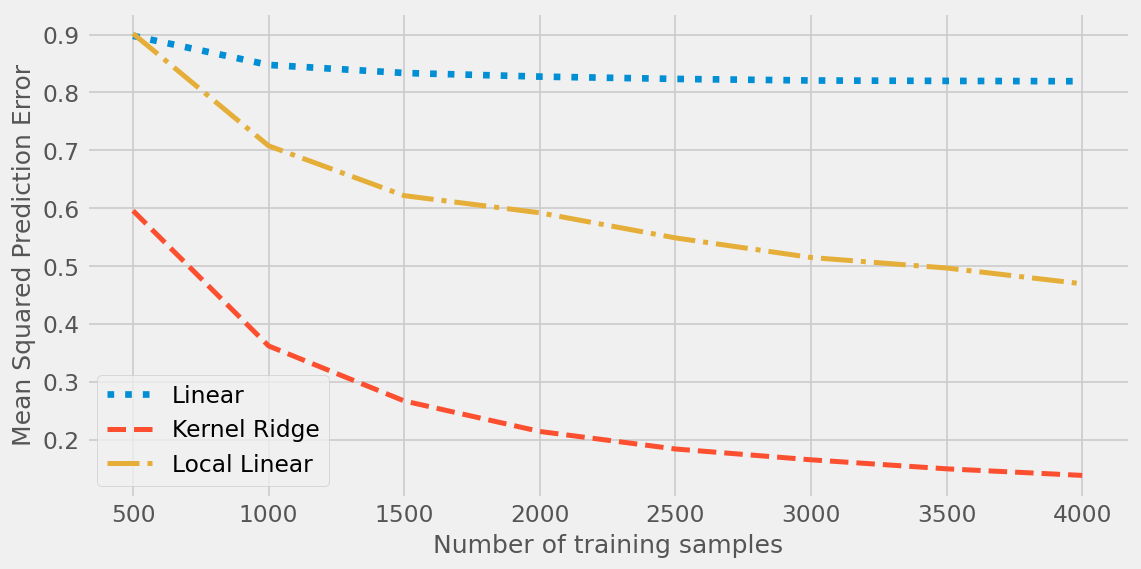

In [17]:
if True:
    plt.figure(figsize=(10, 5), dpi=120)
    plt.plot(ntrains, (results1[:,0]**2).mean(axis=2).mean(axis=0), 
             linewidth=4, linestyle='dotted', label='Linear')
    plt.plot(ntrains, (results1[:,1]**2).mean(axis=2).mean(axis=0), 
             linewidth=3, linestyle='dashed', label='Kernel Ridge')
    plt.plot(ntrains, (results1[:,2]**2).mean(axis=2).mean(axis=0), 
             linewidth=3, linestyle='dashdot', label='Local Linear')
    plt.xlabel('Number of training samples', fontsize=15)
    plt.ylabel('Mean Squared Prediction Error', fontsize=15)
    plt.legend()
    plt.show()

## 3. Estimation under Univariate Model

### Data visualization

Data are generated from a univariate heteroscedastic model $$y = x \sin (1.75 \pi x) +\{ 0.5 + |\sin(0.5 \pi x ) |\} \varepsilon,$$
where $x\sim {\rm Uniform}(0, 2)$ and $\varepsilon \sim N(0, 1)$ are independent. 

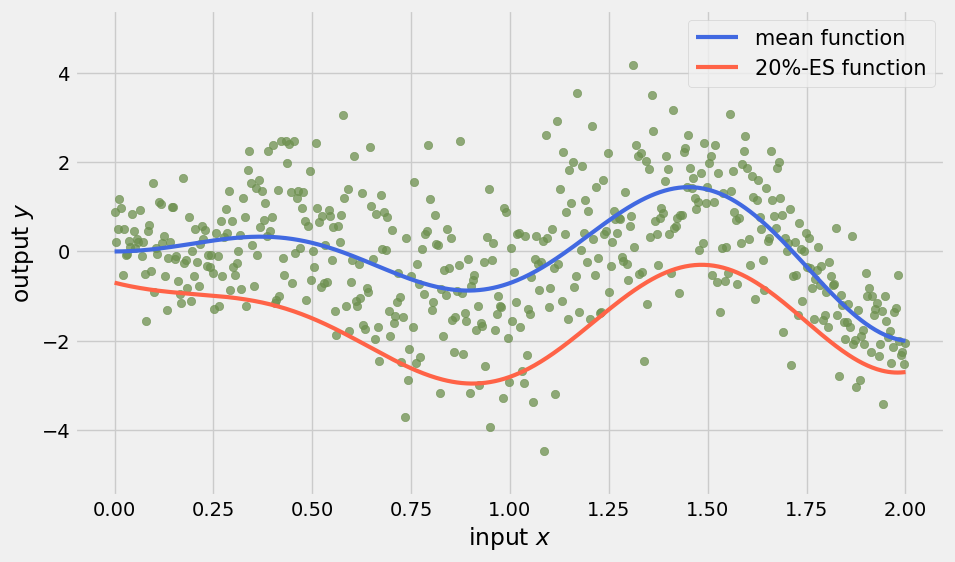

In [5]:
rgt.seed(0)
xx = np.linspace(0, 2, 500)
yy = m1_fn(xx) + s1_fn(xx) * rgt.normal(0, 1, len(xx))

tau = 0.2
plt.figure(figsize=(10, 6), dpi=100)
plt.plot(xx, m1_fn(xx), label='mean function', color='royalblue', linewidth=3)
plt.plot(xx, es_fn(xx, tau), label='20%-ES function', linewidth=3, color='tomato')
plt.scatter(xx, yy, color='C3', alpha=.75)
plt.xlabel('input $x$')
plt.ylabel('output $y$')
plt.ylim(np.min(yy)-1, np.max(yy)+1.25)
plt.legend(fontsize=15)
plt.show()

### Setting and functions

In [24]:
x_seq = np.arange(.25, 1.8, 0.05)
true_e = es_fn(x_seq, tau)

grid_q = 10 ** np.linspace(-7, -2, 20)   
grid_e = 10 ** np.linspace(-7, -2, 20)
bw_q = np.exp(np.linspace(-5, -.5, 20))
bw_e = np.exp(np.linspace(-5, -.5, 20))

In [25]:
def univariate_sim(i, ntrain):
    error = np.empty((len(x_seq), 2))
    X, Y, X_val, Y_val = gen_train(ntrain, ntrain // 4, i)
    
    # fit kernel ridge ES regression 
    # the validation set is used to choose the ridge penalty level 
    kr = QtES_KR(X, Y, X_val, Y_val, tau, 'rbf', grid_q, grid_e, solver='cvxopt')
    error[:,0] = kr['model'].model_e.predict(x_seq.reshape(-1, 1)) - true_e

    # fit local linear ES regression
    # the validation set is used to choose the bandwidth
    ll = QtES_LP(X, Y, X_val, Y_val, tau, 
                 norm.pdf, bw_q, 1, norm.pdf, bw_e, 1)
    ll_e = LocPoly(X, ll['surrogate_y'], kernel=norm.pdf)
    error[:,1] = ll_e.ls_predict(x_seq.reshape(-1,1), ll['bw_e'], 1) - true_e

    return error

### Start simulations

In [ ]:
nsim = 500
results2 = np.array(Parallel(n_jobs=-1)(delayed(univariate_sim)(i, ntrain=1000)
                                        for i in tqdm(range(nsim))))

### Plot results

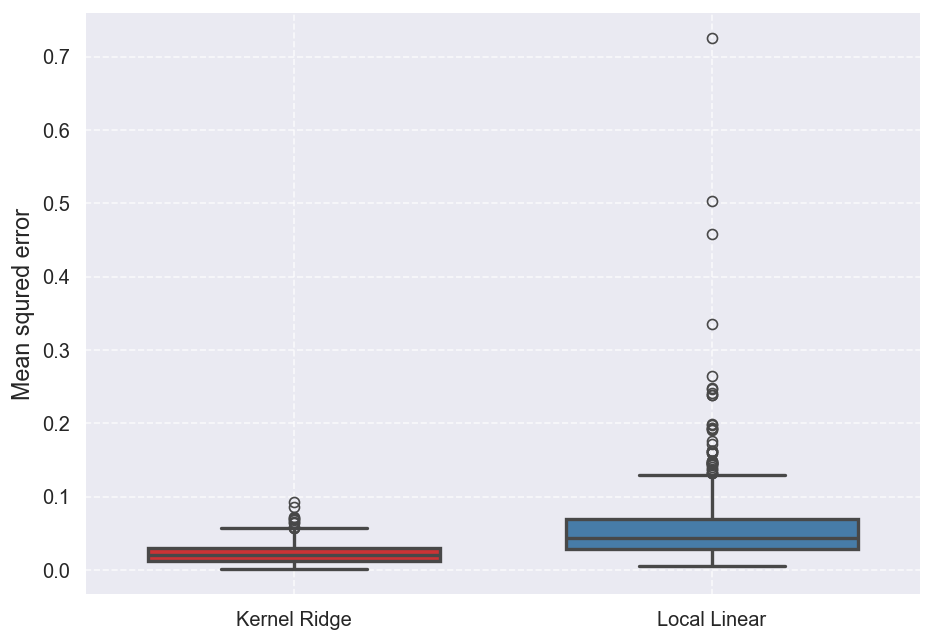

In [28]:
mse_df = pd.DataFrame((results2 ** 2).mean(axis=1), 
                       columns=['Kernel Ridge', 'Local Linear'])

sns.set(style="darkgrid")
plt.figure(figsize=(8, 6), dpi=120)
sns.boxplot(data=mse_df, 
            palette="Set1",
            linewidth=2, width=0.7)
plt.ylabel('Mean squred error', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## 4. Inference under Univariate Model

### Setting and functions

In [6]:
tau = 0.25
x_seq = np.linspace(0.1, 1.9, 37) 
true_e = es_fn(x_seq, tau)

n = 1500
grid_q, alpha_q = 10**np.linspace(-6, -2, 10), []
grid_e, alpha_e = 10**np.linspace(-5, -1, 20), []
gamma = 1

In [7]:
def sim_parallel(m):
    X, Y, _, _ = gen_train(n, random_state=m)
    cv_q = CV_Qt_KR(X, Y, tau, 'rbf', grid_q, {'gamma': gamma}, 
                    random_state=m, nfolds=10, smooth=True)
    cv_e = CV_ES_KR(X, Y, tau, 'rbf', cv_q['alpha_q'], grid_e, {'gamma': gamma}, 
                    random_state=m+1, nfolds=10, smooth=True)
    alpha_q = cv_q['alpha_q']
    alpha_e = cv_e['alpha_e']
    krr = KRR(X, Y, kernel='rbf', kernel_params={'gamma': gamma})
    krr.es(tau=tau, alpha=alpha_e, alpha_q=alpha_q, smooth=True, tol_q=1e-10, x=x_seq.reshape(-1, 1))
    est = krr.pred_e
    boot_stats = (2*rgt.binomial(1, .5, (2*n, n)) -1) @ krr.bahadur(x_seq.reshape(-1, 1))
    lb = est - np.quantile(boot_stats, .975, axis=0)
    ub = est - np.quantile(boot_stats, .025, axis=0)
    covers = (true_e>=lb)*(true_e<=ub)
    widths = ub - lb
    return covers, widths, est, lb, ub, alpha_q, alpha_e

### Start simulations

In [ ]:
nsim = 1000
results3 = Parallel(n_jobs=-1)(delayed(sim_parallel)(m) 
                               for m in tqdm(range(nsim)))
covers1 = np.array([results3[i][0] for i in range(nsim)])
widths1 = np.array([results3[i][1] for i in range(nsim)])

In [ ]:
if False:
    import pickle

    np.save('results1.npy', results1)
    np.save('results2.npy', results2)
    with open('results3.pkl', 'wb') as f:
        pickle.dump(results3, f)

### Plot results

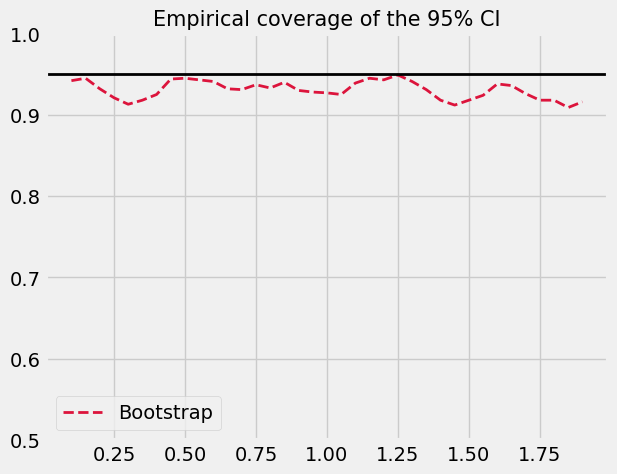

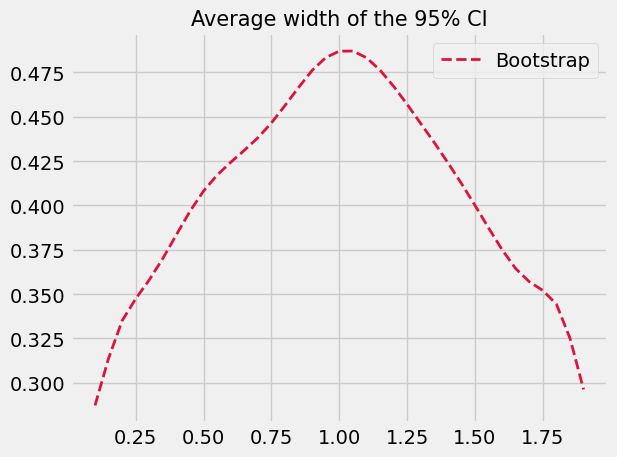

In [32]:
plt.plot(x_seq, covers1.mean(axis=0), label='Bootstrap', 
         color = 'crimson', linestyle='dashed', linewidth=2)
plt.axhline(0.95, color='black', linestyle='-', linewidth=2)
plt.legend()
plt.ylim(.5, 1)
plt.tight_layout()
plt.title('Empirical coverage of the 95% CI', fontsize=15)
plt.show()

plt.plot(x_seq, widths1.mean(axis=0), label='Bootstrap',
         color = 'crimson', linestyle='dashed', linewidth=2)
plt.legend()
plt.title('Average width of the 95% CI', fontsize=15)
plt.tight_layout()
plt.show()

# End